In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import weibull_min
import numpy as np

# Leitura dos dados
df = pd.read_csv('crato.txt', delimiter=';')

In [19]:
# Função para calcular as datas e intervalos entre chuvas fortes
def calcular_datas_e_intervalos(df):
    # Lista para armazenar as datas das chuvas fortes
    datas_chuva_forte = []
    
    # Iterar sobre cada linha do DataFrame
    for index, row in df.iterrows():
        ano = int(row['Anos'])
        mes = int(row['Meses'])
        
        # Iterar sobre os dias (Dia1 a Dia31)
        for dia in range(1, 32):
            coluna_dia = f'Dia{dia}'
            if coluna_dia in row and row[coluna_dia] > 100 and row[coluna_dia] < 888:  # Chuva forte > 100mm
                # Criar a data no formato datetime
                data = datetime(day=dia, month=mes, year=ano)
                datas_chuva_forte.append(data)
    
    # Calcular os intervalos entre as chuvas fortes
    intervalos = []
    for i in range(1, len(datas_chuva_forte)):
        intervalo = (datas_chuva_forte[i] - datas_chuva_forte[i-1]).days
        intervalos.append(intervalo)
    
    # Retornar as datas das chuvas fortes e os intervalos
    return datas_chuva_forte, intervalos

# Executar a função para obter as datas e intervalos
datas_chuva_forte, intervalos = calcular_datas_e_intervalos(df)

# Ajustar a distribuição de Weibull aos intervalos
params = weibull_min.fit(intervalos, floc=0)  # Ajustar a Weibull aos intervalos
beta, eta = params[0], params[2]  # Parâmetros de forma (beta) e escala (eta)

print(f"Parâmetro de forma (β): {beta:.2f}")
print(f"Parâmetro de escala (η): {eta:.2f}")

Parâmetro de forma (β): 1.35
Parâmetro de escala (η): 811.25


In [20]:
# Prever a próxima chuva forte usando a CDF da Weibull
def prever_proxima_chuva_cdf(datas_chuva_forte, beta, eta):
    # Última data de chuva forte
    ultima_data = datas_chuva_forte[-1]
    
    # Calcular a CDF para diferentes intervalos
    x = np.linspace(0, max(intervalos) * 1.2, 1000)
    cdf = weibull_min.cdf(x, beta, scale=eta)  # Função de distribuição acumulada (CDF)
    
    # Definir um limiar de probabilidade (ex: 50% para a mediana)
    limiar_probabilidade = 0.5
    intervalo_previsto = x[np.argmax(cdf >= limiar_probabilidade)]
    
    # Calcular a data prevista para a próxima chuva forte
    data_prevista = ultima_data + timedelta(days=int(intervalo_previsto))
    
    return data_prevista, intervalo_previsto

# Prever a próxima chuva forte usando a CDF
data_prevista, intervalo_previsto = prever_proxima_chuva_cdf(datas_chuva_forte, beta, eta)

# Calcular o intervalo entre a data prevista e a data de hoje
data_hoje = datetime.now()
intervalo_hoje = (data_prevista - data_hoje).days

print(f"Próxima chuva forte prevista para: {data_prevista.strftime('%d/%m/%Y')}")
print(f"Intervalo até a data prevista: {intervalo_hoje} dias")

Próxima chuva forte prevista para: 18/09/2026
Intervalo até a data prevista: 545 dias


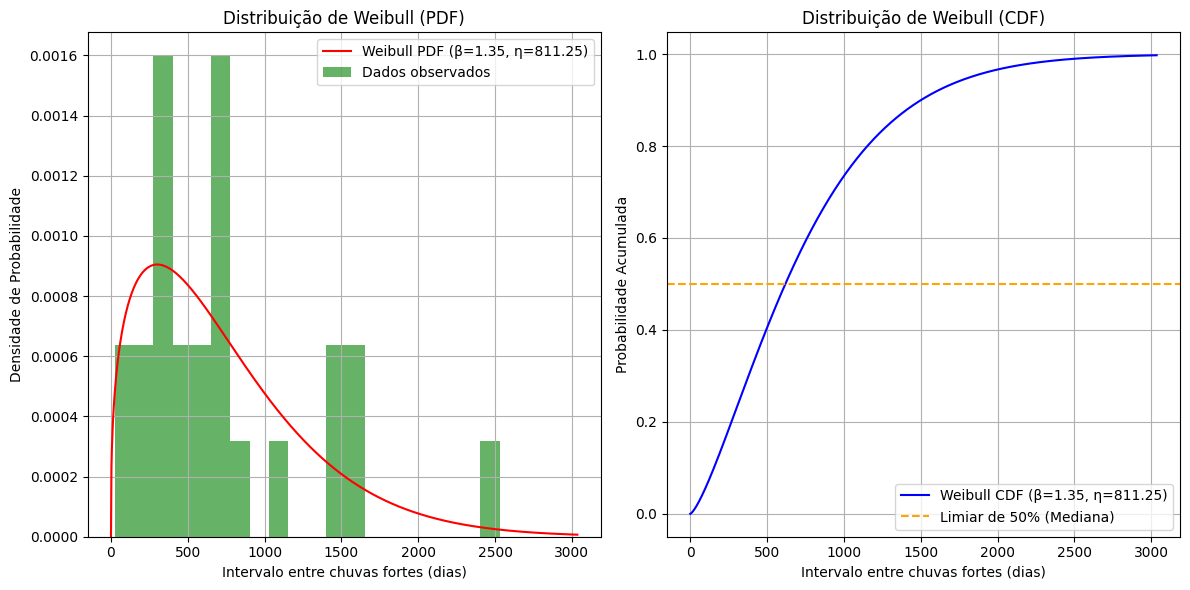

In [21]:
# Plotar a distribuição de Weibull ajustada (PDF e CDF)
plt.figure(figsize=(12, 6))

# PDF
plt.subplot(1, 2, 1)
x = np.linspace(0, max(intervalos) * 1.2, 1000)
pdf = weibull_min.pdf(x, beta, scale=eta)  # Função de densidade de probabilidade (PDF)
plt.plot(x, pdf, 'r-', label=f'Weibull PDF (β={beta:.2f}, η={eta:.2f})')
plt.hist(intervalos, density=True, bins=20, alpha=0.6, color='g', label='Dados observados')
plt.title('Distribuição de Weibull (PDF)')
plt.xlabel('Intervalo entre chuvas fortes (dias)')
plt.ylabel('Densidade de Probabilidade')
plt.legend()
plt.grid(True)

# CDF
plt.subplot(1, 2, 2)
cdf = weibull_min.cdf(x, beta, scale=eta)  # Função de distribuição acumulada (CDF)
plt.plot(x, cdf, 'b-', label=f'Weibull CDF (β={beta:.2f}, η={eta:.2f})')
plt.axhline(y=0.5, color='orange', linestyle='--', label='Limiar de 50% (Mediana)')
plt.title('Distribuição de Weibull (CDF)')
plt.xlabel('Intervalo entre chuvas fortes (dias)')
plt.ylabel('Probabilidade Acumulada')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()